In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
from IPython.display import display
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy.stats as stats
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, DiscriminationThreshold, ClassificationReport, PrecisionRecallCurve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [4]:
final_data = pd.read_csv('final_project.csv')

### Code

In [5]:
def transform_data(data):
    '''
        Runs OHE and standard scaling on any dataframe
    '''
    label_encode = [
        x for x, y in dict(data.dtypes).items()
        if type(y) == pd.CategoricalDtype
    ]
    for var in label_encode:
        #impute to Mode
        print(f"{var} was OHE'd", end='\r')
        data[var].fillna(data[var].mode()[0], inplace=True)
        cat_list = pd.get_dummies(data[var], prefix=var)
        data_new = data.join(cat_list)
        data = data_new

    normalize = [x for x, y in dict(data.dtypes).items() if y == np.float64]
    for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled", end='\r')
        data[col].fillna(data[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar_train = data[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar_train)
        data.loc[:, col] = normalizer.transform(ar_train)

    data.drop(columns=label_encode, inplace=True)
    #data.drop(columns=target_col, inplace=True)

    return data


def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    '''
        Create a df of predictions and probabilities based off of a provided cutoff value
    '''
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([
        pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']),
        predictions
    ],
                                axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(
        lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={
        0: 'No_Predicted',
        1: 'Yes_Predicted'
    },
                  index={
                      0: 'No_True',
                      1: 'Yes_True'
                  },
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),
                 5), matrix, predicted_probs



def compare_classifiers(clf_1, clf_2, title_1, title_2, X_train, X_test,
                        y_train, y_test):
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

    yb_confusion_matrix(clf_1, X_train, X_test, y_train, y_test, ax=ax[0][0])

    yb_confusion_matrix(clf_2, X_train, X_test, y_train, y_test, ax=ax[0][1])
    ax[0][0].set_title(f'Confusion Matrix: {title_1}')
    ax[0][1].set_title(f'Confusion Matrix: {title_2}')

    yb_class_report(clf_1, X_train, X_test, y_train, y_test, ax=ax[1][0])
    yb_class_report(clf_2, X_train, X_test, y_train, y_test, ax=ax[1][1])
    ax[1][0].set_title(f'Class Report: {title_1}')
    ax[1][1].set_title(f'Class Report: {title_2}')

    score_1 = yb_roc_auc(clf_1, X_train, X_test, y_train, y_test, ax=ax[2][0])

    score_2 = yb_roc_auc(clf_2, X_train, X_test, y_train, y_test, ax=ax[2][1])
    ax[2][0].set_title(f'ROC/AUC: {title_1} - {score_1}')
    ax[2][1].set_title(f'ROC/AUC: {title_2} - {score_2}')

    yb_recall(clf_1, X_train, X_test, y_train, y_test, ax=ax[3][0])

    yb_recall(clf_2, X_train, X_test, y_train, y_test, ax=ax[3][1])
    ax[3][0].set_title(f'Precision/Recall: {title_1}')
    ax[3][1].set_title(f'Precision Recall: {title_2}')
    fig.tight_layout()
    
    
def yb_confusion_matrix(model,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        response='y',
                        classes=[0, 1],
                        ax=None):
    matrix = ConfusionMatrix(model, classes=classes, ax=ax)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.finalize()


def yb_class_report(model,
                    X_train,
                    X_test,
                    y_train,
                    y_test,
                    response='y',
                    classes=[0, 1],
                    ax=None):
    class_report = ClassificationReport(model,
                                        classes=classes,
                                        support=True,
                                        ax=ax)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.finalize()


def yb_roc_auc(model,
               X_train,
               X_test,
               y_train,
               y_test,
               response='y',
               classes=[0, 1],
               ax=None):
    roc_auc = ROCAUC(model, classes=classes, ax=ax)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.finalize()
    return roc_auc.score_


def yb_recall(model,
              X_train,
              X_test,
              y_train,
              y_test,
              response='y',
              classes=[0, 1],
              ax=None):
    recall = PrecisionRecallCurve(model, ax=ax)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.finalize()


def analyze_classifier(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='y',
                       classes=[0, 1],
                       discrimination=False):
    matrix = ConfusionMatrix(model, classes=classes)
    #matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    #class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    #roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    recall = PrecisionRecallCurve(model, is_fitted=True)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    if discrimination:
        disc_thresh = DiscriminationThreshold(model)
        disc_thresh.fit(X_train, y_train.values.ravel())
        disc_thresh.show()
        return disc_thresh.thresholds_, disc_thresh.cv_scores_
    else:
        return None, None

In [6]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159974 non-null  float64
 1   x1      159975 non-null  float64
 2   x2      159962 non-null  float64
 3   x3      159963 non-null  float64
 4   x4      159974 non-null  float64
 5   x5      159963 non-null  float64
 6   x6      159974 non-null  float64
 7   x7      159973 non-null  float64
 8   x8      159979 non-null  float64
 9   x9      159970 non-null  float64
 10  x10     159957 non-null  float64
 11  x11     159970 non-null  float64
 12  x12     159964 non-null  float64
 13  x13     159969 non-null  float64
 14  x14     159966 non-null  float64
 15  x15     159965 non-null  float64
 16  x16     159974 non-null  float64
 17  x17     159973 non-null  float64
 18  x18     159960 non-null  float64
 19  x19     159965 non-null  float64
 20  x20     159962 non-null  float64
 21  x21     15

### Deliverable:
Classify the column labeled 'y'

I want you to minimize my dollar cost on an UNKNOWN dataset
That means one you can never see.  Ever.
- Each False Positive costs me 10
- Each False Negative costs me 500 
- True Positives and True Negatives cost me 0

To this end we will seek to minimize false negatives - i.e - predicting the **negative/0** class when the **positive/1** class is true. 

### Considerations
- Best Practices
- Estimate your model performance on UNKNOWN data.
- Describe why you did what you did.

### Random Forest Classifier

### EDA

In order to ascertain whether not there are fields which should be treated as categorical we will first search for fields with low **cardinality**.

In [7]:
cols = []
for x in final_data.columns:
    #display(md(f'''
    #        {x}:{len(final_data[x].unique())/final_data.shape[0]}
    #'''))
    cols.append({
        'feature':x,
        'cardinality':len(final_data[x].unique())/final_data.shape[0]
    })
pd.DataFrame(cols).sort_values(['cardinality'], ascending=True).head(10).reset_index(drop=True)

,feature,cardinality
0,y,0.000013
1,x24,0.000025
2,x30,0.000037
3,x32,0.000075
4,x29,0.000081
5,x37,0.807494
6,x23,0.999706
7,x10,0.999731
8,x33,0.999737
9,x34,0.999737


Variables **x24, x30, x32, x29** have exremely low cardinality and are most likely categorical. 

**x37** seems to be variable pricing where a business offers varying price points at different locations or points-of-sale. It could also be a variable representing global retailing of selling products (i.e., goods and services) across the geographical boundaries of a country to the consumers available in the different parts of the world. This relates to some of the other categorical variables such as region, day of week, and month. This is a common approach used by retailers when the costs of offering certain goods and services and the level of market demand justify it. This variable is also containing possible dupes. Examples include the variable pricing of airline tickets, variable interest rates in lending, seasonal variations in prices for certain foods, selectively timed and distributed price promotions, or price per unit.


Investigating counts for each of these variables:

In [8]:
for col in ['x24', 'x30', 'x32', 'x29', 'x37']:
    display(((final_data.groupby([col])['x0'].count() / final_data.shape[0]) *
             100).sort_values(ascending=False))
    

x24
asia       86.839375
euorpe     10.334375
america     2.792500
Name: x0, dtype: float64

x30
wednesday    63.450625
thurday      18.389375
tuesday      17.468125
friday        0.351875
monday        0.305000
Name: x0, dtype: float64

x32
0.00%     40.254375
0.01%     25.473125
-0.01%    21.304375
-0.02%     6.202500
0.02%      4.991250
-0.03%     1.079375
0.03%      0.534375
-0.04%     0.086250
0.04%      0.034375
-0.05%     0.003750
0.05%      0.000625
Name: x0, dtype: float64

x29
July       28.474375
Jun        25.828125
Aug        18.375625
May        13.708125
sept.       6.761875
Apr         4.225000
Oct         1.504375
Mar         0.769375
Nov         0.210625
Feb         0.087500
Dev         0.014375
January     0.005625
Name: x0, dtype: float64

x37
($311.26)      0.00375
($415.46)      0.00375
$618.22        0.00375
$237.40        0.00375
$341.26        0.00375
                ...   
($826.10)      0.00000
($2,209.50)    0.00000
($708.29)      0.00000
$425.93        0.00000
($1,296.27)    0.00000
Name: x0, Length: 129198, dtype: float64

In [9]:
for col in final_data.columns:
    display(((final_data.groupby([col])['x0'].count() / final_data.shape[0]) *
             100).sort_values(ascending=False))

x0
 0.340091    0.001250
 0.062653    0.001250
 0.330456    0.001250
 0.240091    0.001250
-0.238490    0.001250
               ...   
 0.158497    0.000625
 0.158476    0.000625
 0.158472    0.000625
 0.158470    0.000625
-1.592635    0.000625
Name: x0, Length: 159966, dtype: float64

x1
 1.804225     0.001250
 27.988178    0.000625
-2.724816     0.000625
-2.724842     0.000625
-2.725006     0.000625
                ...   
 6.713102     0.000000
-2.165941     0.000000
 6.623182     0.000000
-5.299368     0.000000
-3.036337     0.000000
Name: x0, Length: 159974, dtype: float64

x2
 63.545653    0.000625
-7.036851     0.000625
-7.035960     0.000625
-7.036160     0.000625
-7.036302     0.000625
                ...   
-2.088747     0.000000
-24.610417    0.000000
-46.839020    0.000000
-8.791735     0.000000
-0.632413     0.000000
Name: x0, Length: 159962, dtype: float64

x3
 6.370036     0.001250
 38.906025    0.000625
-3.497350     0.000625
-3.496279     0.000625
-3.496289     0.000625
                ...   
-1.097076     0.000000
 3.382918     0.000000
 0.077611     0.000000
-3.122131     0.000000
-1.293288     0.000000
Name: x0, Length: 159962, dtype: float64

x4
-2.800204     0.001250
 26.247812    0.000625
-2.765170     0.000625
-2.764718     0.000625
-2.764781     0.000625
                ...   
 0.403259     0.000000
 7.802849     0.000000
-8.015760     0.000000
 7.138210     0.000000
 2.945949     0.000000
Name: x0, Length: 159973, dtype: float64

x5
-15.447910    0.001250
-15.153105    0.001250
 13.203007    0.001250
 4.943089     0.001250
-3.281831     0.000625
                ...   
 2.691191     0.000000
 1.514197     0.000000
-2.915002     0.000000
 5.957515     0.000000
-2.076274     0.000000
Name: x0, Length: 159959, dtype: float64

x6
 92.390605    0.000625
-10.230820    0.000625
-10.227914    0.000625
-10.227933    0.000625
-10.228999    0.000625
                ...   
-10.768259    0.000000
 2.297553     0.000000
-35.781698    0.000000
 16.259005    0.000000
-25.290936    0.000000
Name: x0, Length: 159974, dtype: float64

x7
 149.150634    0.000625
-19.831822     0.000625
-19.827648     0.000625
-19.827949     0.000625
-19.827954     0.000625
                 ...   
 55.218790     0.000000
-20.290116     0.000000
-0.154718      0.000000
-17.821345     0.000000
-30.720431     0.000000
Name: x0, Length: 159973, dtype: float64

x8
-9.252842     0.001250
 39.049831    0.000625
-3.870544     0.000625
-3.869439     0.000625
-3.869788     0.000625
                ...   
-6.269125     0.000000
 7.593877     0.000000
 13.608205    0.000000
 5.342152     0.000000
-6.684410     0.000000
Name: x0, Length: 159978, dtype: float64

x9
 27.377842    0.000625
-2.706392     0.000625
-2.705804     0.000625
-2.705816     0.000625
-2.705823     0.000625
                ...   
 3.009472     0.000000
-9.870912     0.000000
-6.329517     0.000000
 3.828591     0.000000
-5.495107     0.000000
Name: x0, Length: 159970, dtype: float64

x10
 2.990344     0.001250
 37.945583    0.000625
-3.380391     0.000625
-3.380603     0.000625
-3.380815     0.000625
                ...   
 9.542608     0.000000
-12.334210    0.000000
-4.098871     0.000000
-9.514786     0.000000
-0.801174     0.000000
Name: x0, Length: 159956, dtype: float64

x11
-13.407450    0.001250
 12.433845    0.001250
-0.114112     0.001250
-3.761380     0.000625
-3.759842     0.000625
                ...   
-13.972060    0.000000
-0.724034     0.000000
-7.483634     0.000000
 4.561011     0.000000
 10.384946    0.000000
Name: x0, Length: 159967, dtype: float64

x12
 12.399511    0.001250
 73.279354    0.000625
-7.874681     0.000625
-7.874348     0.000625
-7.874365     0.000625
                ...   
-7.153401     0.000000
-14.789910    0.000000
 6.948290     0.000000
-13.664367    0.000000
-5.204155     0.000000
Name: x0, Length: 159963, dtype: float64

x13
-2.670653     0.001250
 42.392177    0.000625
-3.855518     0.000625
-3.855672     0.000625
-3.855704     0.000625
                ...   
-13.362849    0.000000
 8.647555     0.000000
-5.781862     0.000000
-13.858487    0.000000
 0.269799     0.000000
Name: x0, Length: 159968, dtype: float64

x14
 0.488355     0.001250
 32.546340    0.000625
-3.011955     0.000625
-3.010864     0.000625
-3.011029     0.000625
                ...   
 2.569586     0.000000
 2.114834     0.000000
-1.220899     0.000000
-12.411944    0.000000
-4.570301     0.000000
Name: x0, Length: 159965, dtype: float64

x15
 4.606501    0.001250
 0.210331    0.001250
-1.406188    0.000625
-1.405508    0.000625
-1.405553    0.000625
               ...   
 2.936831    0.000000
 9.273935    0.000000
-2.755755    0.000000
-0.780579    0.000000
 1.051802    0.000000
Name: x0, Length: 159963, dtype: float64

x16
 21.961123    0.000625
-2.135936     0.000625
-2.134596     0.000625
-2.134617     0.000625
-2.135069     0.000625
                ...   
 4.516131     0.000000
-6.214514     0.000000
-3.890345     0.000000
-4.359950     0.000000
-0.601953     0.000000
Name: x0, Length: 159974, dtype: float64

x17
 37.057048    0.000625
-3.237360     0.000625
-3.236525     0.000625
-3.236716     0.000625
-3.236835     0.000625
                ...   
 3.758949     0.000000
 3.821809     0.000000
-11.951127    0.000000
-7.889524     0.000000
-8.257691     0.000000
Name: x0, Length: 159973, dtype: float64

x18
 19.652986    0.000625
-1.960498     0.000625
-1.960047     0.000625
-1.960191     0.000625
-1.960197     0.000625
                ...   
-0.206676     0.000000
-1.146420     0.000000
-1.059523     0.000000
 2.078426     0.000000
-5.507149     0.000000
Name: x0, Length: 159960, dtype: float64

x19
 1.387237     0.001250
-13.965027    0.001250
-3.245206     0.000625
-3.244738     0.000625
-3.244868     0.000625
                ...   
-3.536897     0.000000
 10.187825    0.000000
 2.678927     0.000000
 9.113589     0.000000
 5.063237     0.000000
Name: x0, Length: 159963, dtype: float64

x20
 27.814560    0.000625
-2.140538     0.000625
-2.139696     0.000625
-2.140115     0.000625
-2.140145     0.000625
                ...   
 7.446191     0.000000
-1.767083     0.000000
 2.163785     0.000000
 0.283070     0.000000
-7.269792     0.000000
Name: x0, Length: 159962, dtype: float64

x21
 46.237503    0.000625
-4.072413     0.000625
-4.071668     0.000625
-4.071674     0.000625
-4.071689     0.000625
                ...   
 5.560601     0.000000
-6.920631     0.000000
-6.948795     0.000000
 13.503667    0.000000
-11.070022    0.000000
Name: x0, Length: 159971, dtype: float64

x22
 24.863012    0.000625
-2.337259     0.000625
-2.336514     0.000625
-2.336550     0.000625
-2.336551     0.000625
                ...   
-1.455832     0.000000
-2.155609     0.000000
-4.711042     0.000000
-12.023061    0.000000
-2.320974     0.000000
Name: x0, Length: 159973, dtype: float64

x23
 14.384667    0.001250
 58.490500    0.000625
-5.505447     0.000625
-5.505753     0.000625
-5.505861     0.000625
                ...   
-9.522184     0.000000
 9.902647     0.000000
-3.423018     0.000000
-16.726690    0.000000
 19.140203    0.000000
Name: x0, Length: 159952, dtype: float64

x24
asia       86.839375
euorpe     10.334375
america     2.792500
Name: x0, dtype: float64

x25
 0.011836    0.001250
-0.546949    0.000625
-0.546804    0.000625
-0.546816    0.000625
-0.546818    0.000625
               ...   
 0.671687    0.000000
-0.593724    0.000000
 0.375772    0.000000
 0.954924    0.000000
-0.158153    0.000000
Name: x0, Length: 159977, dtype: float64

x26
-0.552932    0.00125
 0.720568    0.00125
-0.066692    0.00125
-0.278329    0.00125
 0.365025    0.00125
              ...   
-0.083207    0.00000
-0.956708    0.00000
 0.612399    0.00000
 1.067025    0.00000
-0.386139    0.00000
Name: x0, Length: 159959, dtype: float64

x27
 11.313286    0.001250
 28.645074    0.000625
-2.937422     0.000625
-2.936688     0.000625
-2.936798     0.000625
                ...   
-3.778666     0.000000
-1.283806     0.000000
-2.566644     0.000000
 12.496125    0.000000
-3.161278     0.000000
Name: x0, Length: 159969, dtype: float64

x28
 10.956542    0.001250
 67.753845    0.000625
-6.133018     0.000625
-6.131532     0.000625
-6.131935     0.000625
                ...   
 4.667171     0.000000
-16.288483    0.000000
-5.784993     0.000000
-1.805991     0.000000
 11.016039    0.000000
Name: x0, Length: 159964, dtype: float64

x29
July       28.474375
Jun        25.828125
Aug        18.375625
May        13.708125
sept.       6.761875
Apr         4.225000
Oct         1.504375
Mar         0.769375
Nov         0.210625
Feb         0.087500
Dev         0.014375
January     0.005625
Name: x0, dtype: float64

x30
wednesday    63.450625
thurday      18.389375
tuesday      17.468125
friday        0.351875
monday        0.305000
Name: x0, dtype: float64

x31
-3.904756     0.001250
 2.131586     0.001250
 1.944908     0.001250
 12.279356    0.000625
-1.188576     0.000625
                ...   
-2.684917     0.000000
 0.314544     0.000000
-2.074337     0.000000
 2.493019     0.000000
 2.486217     0.000000
Name: x0, Length: 159958, dtype: float64

x32
0.00%     40.254375
0.01%     25.473125
-0.01%    21.304375
-0.02%     6.202500
0.02%      4.991250
-0.03%     1.079375
0.03%      0.534375
-0.04%     0.086250
0.04%      0.034375
-0.05%     0.003750
0.05%      0.000625
Name: x0, dtype: float64

x33
-1.359610    0.001250
 0.533957    0.001250
 7.787120    0.000625
-0.762389    0.000625
-0.762062    0.000625
               ...   
 0.788079    0.000000
-1.495809    0.000000
-0.146152    0.000000
 2.006222    0.000000
 1.402357    0.000000
Name: x0, Length: 159957, dtype: float64

x34
 16.105801    0.001250
-2.568339     0.001250
 34.841428    0.000625
-3.470989     0.000625
-3.468735     0.000625
                ...   
 5.468427     0.000000
-7.342156     0.000000
 7.026818     0.000000
 5.675956     0.000000
 0.939663     0.000000
Name: x0, Length: 159957, dtype: float64

x35
-0.852458    0.001250
-1.725767    0.001250
-1.032562    0.000625
-1.032579    0.000625
-1.032618    0.000625
               ...   
 0.268082    0.000000
 0.287140    0.000000
 0.745565    0.000000
-1.265690    0.000000
 1.078483    0.000000
Name: x0, Length: 159968, dtype: float64

x36
 1.258489    0.00125
-0.564226    0.00125
 1.359149    0.00125
 0.902451    0.00125
 1.288470    0.00125
              ...   
 0.908466    0.00000
-2.009552    0.00000
 0.673099    0.00000
 0.007438    0.00000
-0.149577    0.00000
Name: x0, Length: 159967, dtype: float64

x37
($311.26)      0.00375
($415.46)      0.00375
$618.22        0.00375
$237.40        0.00375
$341.26        0.00375
                ...   
($826.10)      0.00000
($2,209.50)    0.00000
($708.29)      0.00000
$425.93        0.00000
($1,296.27)    0.00000
Name: x0, Length: 129198, dtype: float64

x38
-13.329300    0.001250
 90.467981    0.000625
-1.047853     0.000625
-1.044650     0.000625
-1.044796     0.000625
                ...   
-6.825275     0.000000
 7.141419     0.000000
-14.357900    0.000000
-11.624488    0.000000
-21.204511    0.000000
Name: x0, Length: 159968, dtype: float64

x39
-1.781037     0.001250
 21.545591    0.000625
-2.184673     0.000625
-2.185018     0.000625
-2.185027     0.000625
                ...   
-1.755759     0.000000
 2.896516     0.000000
-0.394699     0.000000
-3.269158     0.000000
-4.430506     0.000000
Name: x0, Length: 159976, dtype: float64

x40
-14.963836    0.001250
-18.745595    0.001250
-9.910938     0.000625
-9.910538     0.000625
-9.905034     0.000625
                ...   
 18.529978    0.000000
 1.363844     0.000000
-18.614561    0.000000
-19.590774    0.000000
 7.508441     0.000000
Name: x0, Length: 159962, dtype: float64

x41
 39.806803     0.001250
 100.050432    0.000625
-1.153014      0.000625
-1.153190      0.000625
-1.155300      0.000625
                 ...   
-7.548214      0.000000
 7.897845      0.000000
-15.878702     0.000000
-12.855764     0.000000
 1.467765      0.000000
Name: x0, Length: 159959, dtype: float64

x42
 0.994083     0.001250
 22.668041    0.000625
-3.985846     0.000625
-3.985072     0.000625
-3.985324     0.000625
                ...   
 1.575676     0.000000
 9.851763     0.000000
 1.609133     0.000000
 0.929264     0.000000
-7.449942     0.000000
Name: x0, Length: 159973, dtype: float64

x43
 6.680922    0.000625
-0.668011    0.000625
-0.667732    0.000625
-0.667772    0.000625
-0.667788    0.000625
               ...   
-2.126902    0.000000
-3.343222    0.000000
-0.053725    0.000000
 1.259329    0.000000
-0.751146    0.000000
Name: x0, Length: 159963, dtype: float64

x44
 19.069758    0.000625
-1.789124     0.000625
-1.788795     0.000625
-1.788849     0.000625
-1.788893     0.000625
                ...   
 0.058346     0.000000
-0.431745     0.000000
 0.835870     0.000000
 3.849479     0.000000
 3.943872     0.000000
Name: x0, Length: 159960, dtype: float64

x45
-0.789323    0.00125
 0.223885    0.00125
 0.669664    0.00125
-0.258852    0.00125
-0.309686    0.00125
              ...   
 0.409124    0.00000
-0.261038    0.00000
 0.125611    0.00000
-0.453773    0.00000
-0.335413    0.00000
Name: x0, Length: 159961, dtype: float64

x46
 150.859415    0.000625
-27.865953     0.000625
-27.862973     0.000625
-27.862998     0.000625
-27.863855     0.000625
                 ...   
 1.699792      0.000000
 7.315428      0.000000
-30.941666     0.000000
-17.098157     0.000000
 20.471712     0.000000
Name: x0, Length: 159969, dtype: float64

x47
 1.328838     0.001250
 20.836854    0.000625
-2.053399     0.000625
-2.053440     0.000625
-2.053517     0.000625
                ...   
-1.480369     0.000000
 2.123860     0.000000
 0.713566     0.000000
 0.545275     0.000000
 4.629791     0.000000
Name: x0, Length: 159962, dtype: float64

x48
 8.226552    0.000625
-0.849590    0.000625
-0.849520    0.000625
-0.849525    0.000625
-0.849526    0.000625
               ...   
 0.553154    0.000000
 0.854476    0.000000
-1.387532    0.000000
-0.232055    0.000000
-0.691911    0.000000
Name: x0, Length: 159968, dtype: float64

x49
-12.844580    0.001250
 66.877604    0.000625
-7.235986     0.000625
-7.236231     0.000625
-7.236426     0.000625
                ...   
-21.484319    0.000000
-15.412209    0.000000
 13.675393    0.000000
 3.637819     0.000000
-7.742182     0.000000
Name: x0, Length: 159967, dtype: float64

y
0    59.86500
1    40.11875
Name: x0, dtype: float64

**x24** is clearly **region**

**x30** is clearly **day_of_week**

**x32** should be stripped and parsed as a float

**x29** is Month (and has some misspellings - this could be manually)

In [10]:
final_data.rename(columns={
    'x24': 'region',
    'x30': 'day_of_week',
    'x29': 'month'
},
                  inplace=True)
final_data['x32'] = pd.to_numeric(final_data['x32'].str.replace('%', ''))
final_data['x37'] = pd.to_numeric(final_data['x37'].str.replace(
    '$',
    '').str.replace('(',
                    '').str.replace(')',
                                    '').str.replace(')', '').str.replace(',', ''))

In [11]:
final_data['region'] = final_data['region'].astype('category')
final_data['day_of_week'] = final_data['day_of_week'].astype('category')
final_data['month'] = final_data['month'].astype('category')

### Correlation Matrix

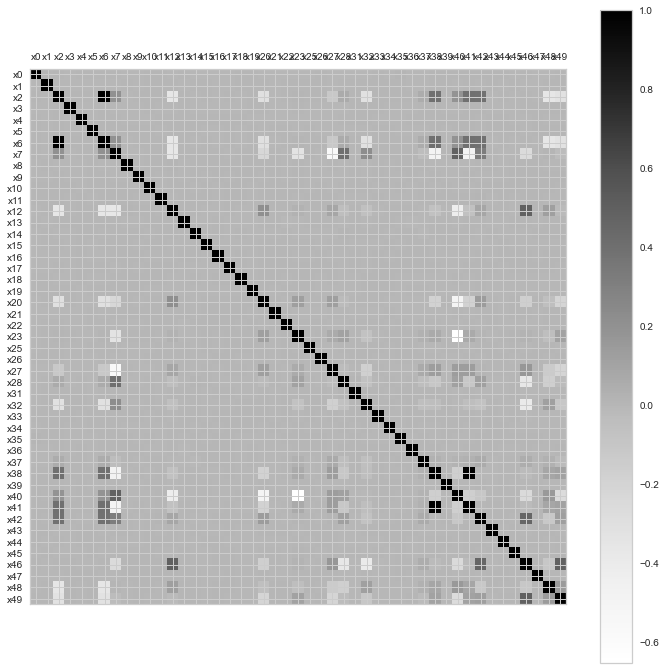

In [12]:
fig, ax = plt.subplots(figsize=(12,12))
floats = [x for x in final_data.columns[final_data.dtypes == 'float64']]
im = ax.matshow(final_data[floats].corr())
ax.set_xticks(np.arange(len(floats))) # force to show all x labels
ax.set_yticks(np.arange(len(floats))) # force to show all y labels
ax.set_xticklabels(floats)
ax.set_yticklabels(floats)
fig.colorbar(im)
plt.show()

In [13]:
correl = final_data[floats].corr()
correl = pd.DataFrame(correl.unstack()).reset_index()
correl = correl[correl.level_0 != correl.level_1]
correl.rename(columns={0:'correlation'}, inplace=True)
correl['absolute_correlation'] = np.abs(correl['correlation'])
correl.sort_values(['absolute_correlation'], ascending=False).head(20)

,level_0,level_1,correlation,absolute_correlation
284,x6,x2,1.000000,1.000000
100,x2,x6,1.000000,1.000000
1821,x41,x38,1.000000,1.000000
1683,x38,x41,1.000000,1.000000
1762,x40,x23,-0.651918,0.651918
1118,x23,x40,-0.651918,0.651918
355,x7,x27,-0.570490,0.570490
1229,x27,x7,-0.570490,0.570490
977,x20,x40,-0.505065,0.505065
1759,x40,x20,-0.505065,0.505065


Variables **x2** and **x6** are clearly the same variable - they are perfectly correlated - as are **x41** and **x38**. In order to avoid issues associated with multicolinearity, we will have to drop one of the features from each pair. Most of the other correlations are relatively low and not statistically significant.

### Normality/Outliers

In [14]:
from sklearn.preprocessing import StandardScaler
#normalized_data = StandardScaler().fit_transform(X=final_data[floats])

In [15]:
#normalized_data = pd.DataFrame(normalized_data, columns=floats)
#final_data = normalized_data

In [16]:
stats.skew(np.array(final_data['x0']))

nan

Below we will use a data frame and boxplots to highlight the descriptive statistics for each variable in the dataset to identify any outliers.   

,x0,x1,x2,x3,x4
count,159974.000000,159975.000000,159962.000000,159963.000000,159974.000000
mean,-0.001028,0.001358,-1.150145,-0.024637,-0.000549
std,0.371137,6.340632,13.273480,8.065032,6.382293
min,-1.592635,-26.278302,-59.394048,-35.476594,-28.467536
25%,-0.251641,-4.260973,-10.166536,-5.454438,-4.313118
50%,-0.002047,0.004813,-1.340932,-0.031408,0.000857
75%,0.248532,4.284220,7.871676,5.445179,4.306660
max,1.600849,27.988178,63.545653,38.906025,26.247812
pcnt_na,0.016250,0.015625,0.023750,0.023125,0.016250
skew,0.009054,-0.004324,0.028515,-0.005986,-0.001835


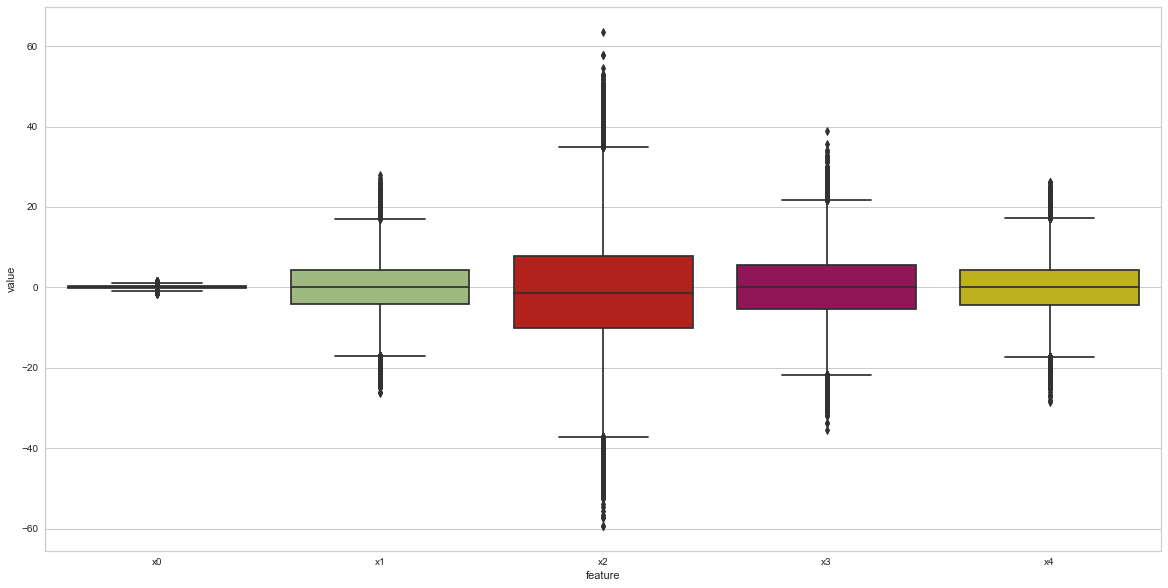

In [17]:
by_value = pd.DataFrame(
    final_data[floats[0:5]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[0:5]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[0:5]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[0:5]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[0:5]]
summary

Of note - all 5 of these variables have close to zero mean, all contain few nas and all seem fairly normal as far as their distributions.

,x5,x6,x7,x8,x9
count,159963.000000,159974.000000,159973.000000,159979.000000,159970.000000
mean,0.013582,-1.670670,-7.692795,-0.030540,0.005462
std,7.670076,19.298665,30.542264,8.901185,6.355040
min,-33.822988,-86.354483,-181.506976,-37.691045,-27.980659
25%,-5.148130,-14.780146,-27.324771,-6.031058,-4.260619
50%,0.014118,-1.948594,-6.956789,-0.016840,0.006045
75%,5.190749,11.446931,12.217071,5.972349,4.305734
max,35.550110,92.390605,149.150634,39.049831,27.377842
pcnt_na,0.023125,0.016250,0.016875,0.013125,0.018750
skew,-0.003351,0.028501,-0.083645,-0.001196,-0.005520


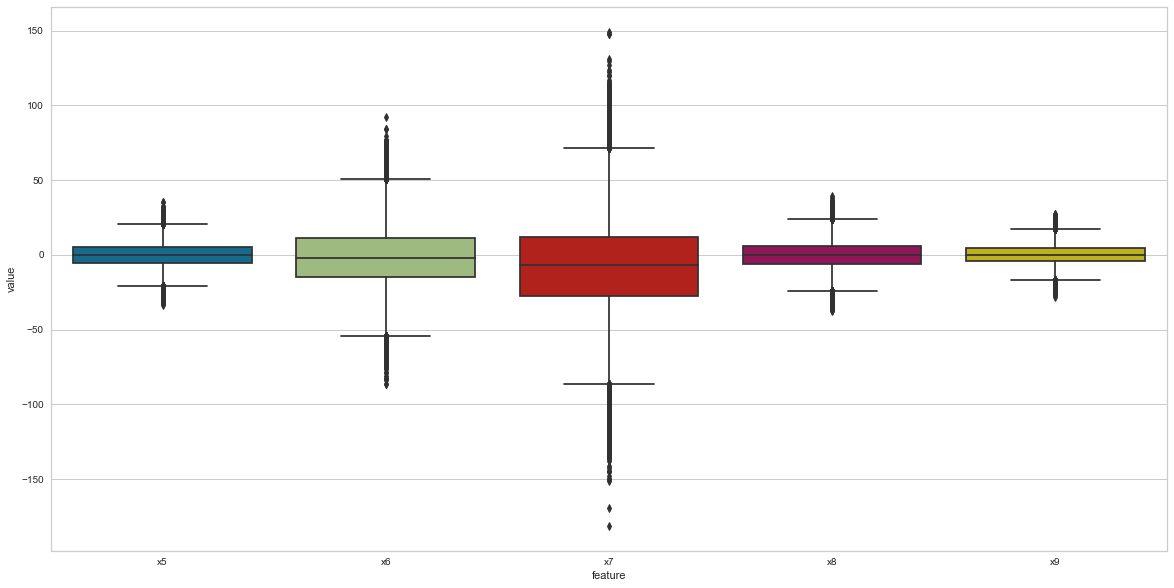

In [18]:
by_value = pd.DataFrame(
    final_data[floats[5:10]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[5:10]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[5:10]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[5:10]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[5:10]]
summary

,x10,x11,x12,x13,x14
count,159957.000000,159970.000000,159964.000000,159969.000000,159966.000000
mean,0.002253,0.030232,-1.334402,0.007669,0.008104
std,7.871429,8.769633,14.750990,8.953837,6.964097
min,-36.306571,-38.092869,-64.197967,-38.723514,-30.905214
25%,-5.288196,-5.903274,-11.379492,-6.029945,-4.696755
50%,-0.018176,0.010941,-1.624439,-0.003473,0.002467
75%,5.331573,5.935032,8.374524,6.041959,4.701299
max,37.945583,36.360443,73.279354,42.392177,32.546340
pcnt_na,0.026875,0.018750,0.022500,0.019375,0.021250
skew,-0.001502,0.007269,0.134047,-0.002510,0.004822


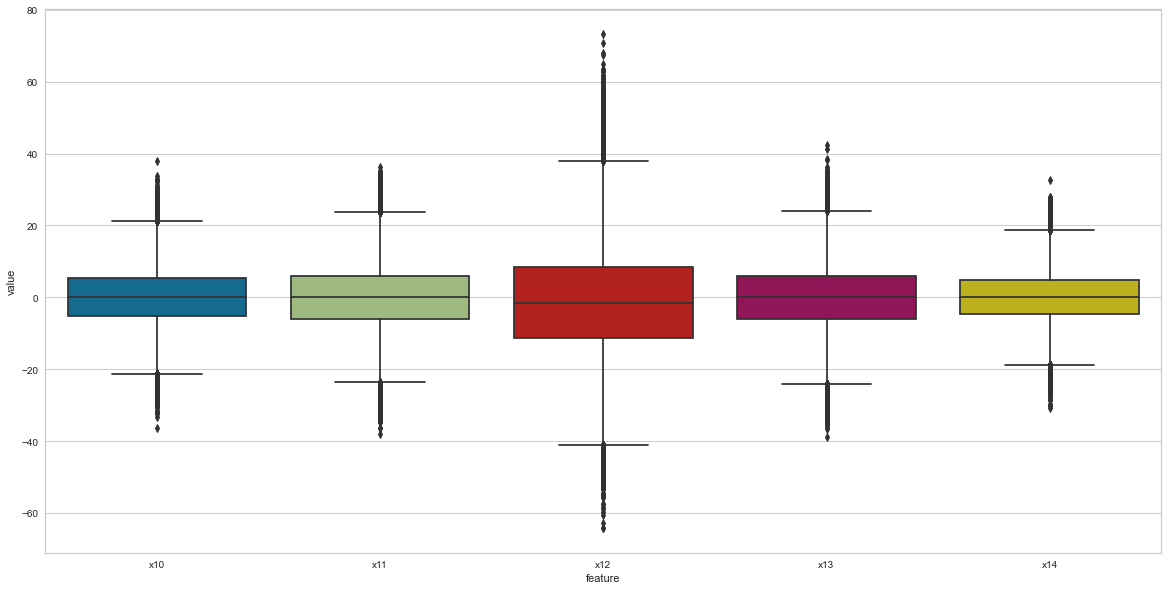

In [19]:
by_value = pd.DataFrame(
    final_data[floats[10:15]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[10:15]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[10:15]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[10:15]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[10:15]]
summary

,x15,x16,x17,x18,x19
count,159965.000000,159974.000000,159973.000000,159960.000000,159965.000000
mean,0.001215,0.006223,0.012040,0.012694,0.024555
std,3.271779,4.984065,7.569351,4.540714,7.595316
min,-17.002359,-26.042983,-34.395898,-20.198686,-35.633396
25%,-2.207774,-3.344027,-5.071470,-3.056131,-5.101553
50%,0.003535,0.012754,0.024541,0.015904,0.044703
75%,2.211660,3.366853,5.101962,3.073002,5.164732
max,13.782559,21.961123,37.057048,19.652986,33.515550
pcnt_na,0.021875,0.016250,0.016875,0.025000,0.021875
skew,-0.004220,-0.005274,-0.001322,0.005659,-0.003413


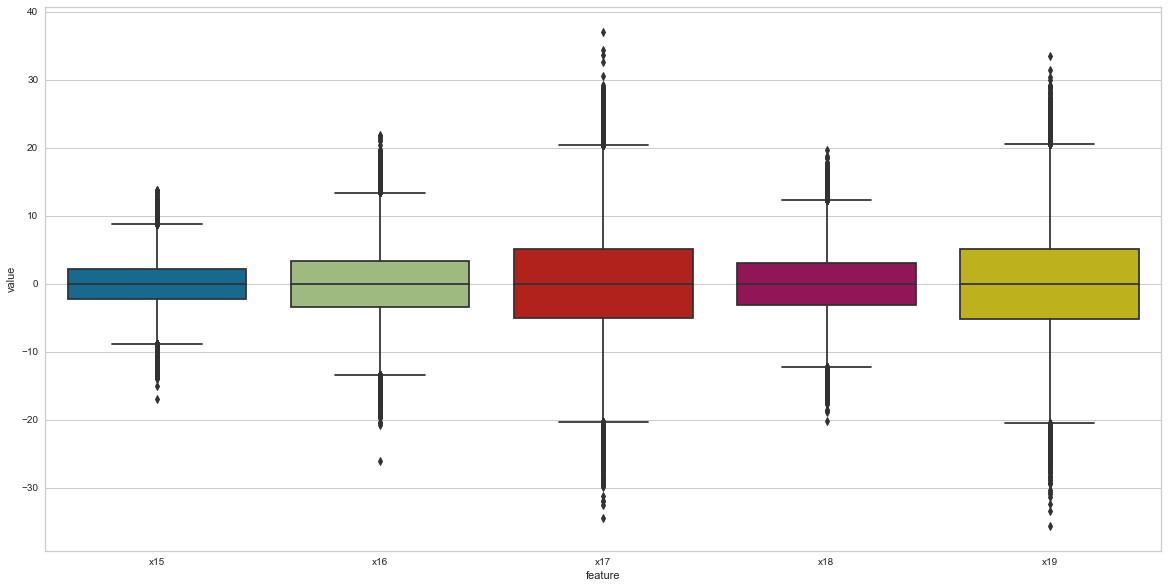

In [20]:
by_value = pd.DataFrame(
    final_data[floats[15:20]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[15:20]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[15:20]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[15:20]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[15:20]]
summary

,x20,x21,x22,x23,x25
count,159962.000000,159971.000000,159973.000000,159953.000000,159978.000000
mean,0.299074,-0.029137,0.008400,0.722028,-0.000806
std,5.806203,9.409635,5.412010,14.909127,1.263656
min,-26.677396,-43.501854,-23.644193,-66.640341,-6.364653
25%,-3.607789,-6.361115,-3.649766,-9.268532,-0.852784
50%,0.433055,-0.026385,0.011144,1.029609,-0.003723
75%,4.306566,6.316457,3.672678,11.028035,0.851765
max,27.814560,46.237503,24.863012,58.490500,5.314169
pcnt_na,0.023750,0.018125,0.016875,0.029375,0.013750
skew,-0.086968,-0.008446,-0.003498,-0.110727,0.001343


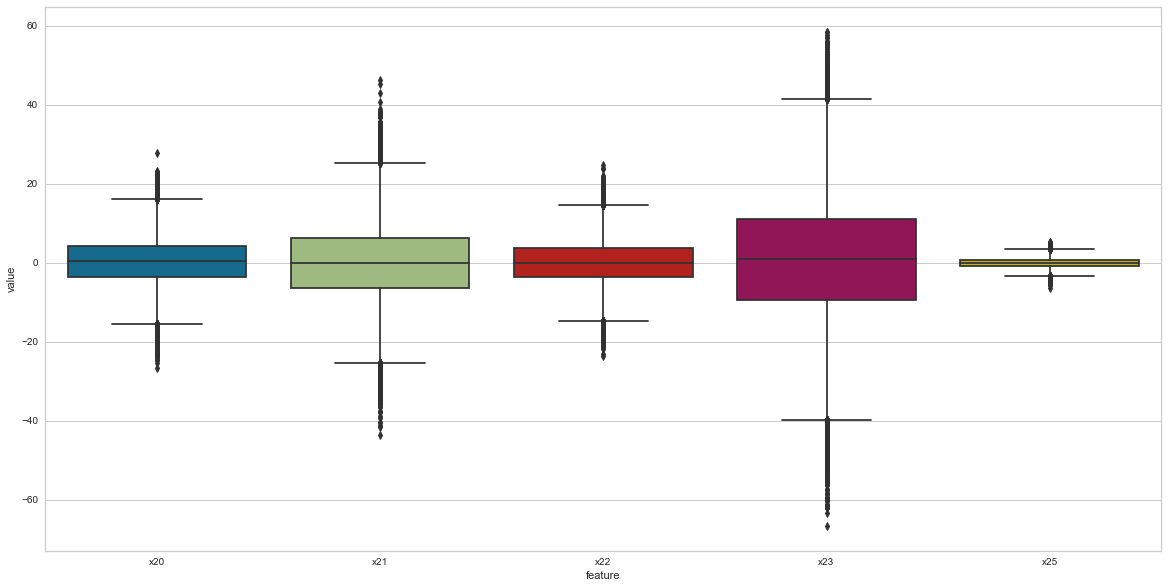

In [21]:
by_value = pd.DataFrame(
    final_data[floats[20:25]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[20:25]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[20:25]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[20:25]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[20:25]]
summary

,x26,x27,x28,x31,x32
count,159964.000000,159970.000000,159965.000000,159961.000000,159969.000000
mean,-0.001066,-0.004159,0.031543,-0.005945,-0.000011
std,0.843258,6.774047,14.439534,2.767508,0.010400
min,-3.857484,-32.003555,-72.896705,-12.289364,-0.050000
25%,-0.567293,-4.597919,-9.702464,-1.874206,-0.010000
50%,-0.001501,0.037138,0.244210,0.002013,0.000000
75%,0.567406,4.649773,9.936995,1.856369,0.010000
max,3.951652,28.645074,67.753845,12.279356,0.050000
pcnt_na,0.022500,0.018750,0.021875,0.024375,0.019375
skew,-0.005505,-0.025719,-0.080877,-0.002010,-0.209781


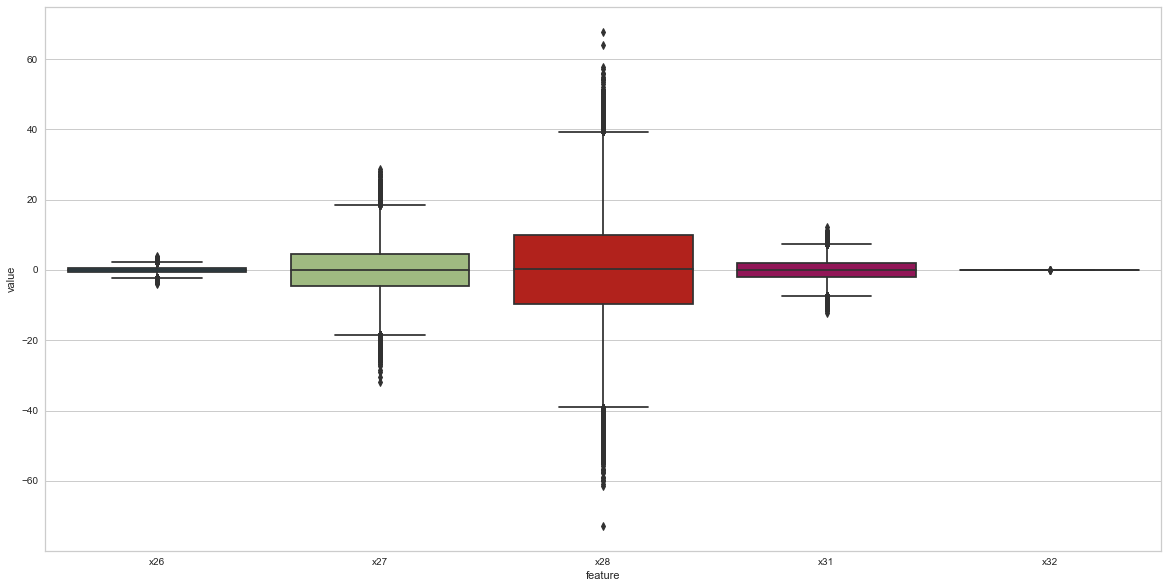

In [22]:
by_value = pd.DataFrame(
    final_data[floats[25:30]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[25:30]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[25:30]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[25:30]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[25:30]]
summary

,x33,x34,x35,x36,x37
count,159959.000000,159959.000000,159970.000000,159973.000000,159977.000000
mean,-0.006567,-0.000426,0.000936,0.006453,797.187917
std,1.747762,8.014180,2.379558,1.593183,603.637528
min,-7.451454,-36.116606,-10.008149,-6.866024,0.030000
25%,-1.183681,-5.401084,-1.610337,-1.068337,323.210000
50%,-0.006079,-0.013089,-0.002399,0.003645,677.790000
75%,1.179460,5.411667,1.603089,1.079895,1137.500000
max,7.787120,34.841428,9.892426,6.999544,5546.990000
pcnt_na,0.025625,0.025625,0.018750,0.016875,0.014375
skew,-0.003289,0.001995,0.011465,0.003550,1.110171


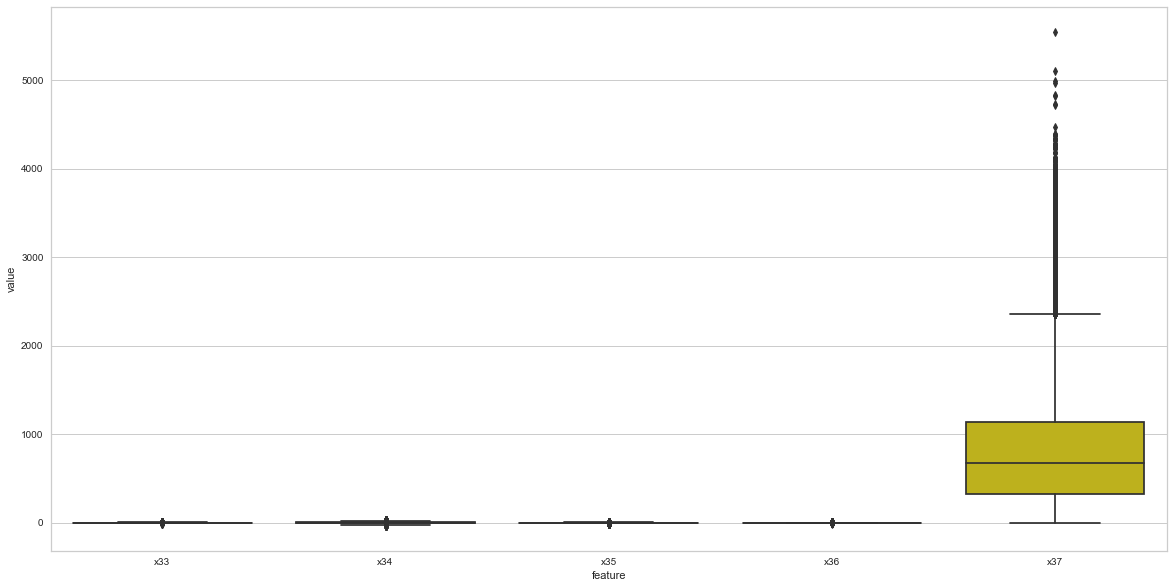

In [23]:
by_value = pd.DataFrame(
    final_data[floats[30:35]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[30:35]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[30:35]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[30:35]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[30:35]]
summary

The variable x37 sticks out from the above table compared to the other variables. As stated above, the variable x37 seems to be the only variable in the dataset that appears to be a price value. Some of the reasons this variable sticks out is due to the mean of 797.28, which makes sense since it is possibly a price variable which ranges from 0.03 all the way up to 5546. Based on the descriptive statistics, you can see that x37 has high values in both the skew, with a value of 1.11 and a value of 1.53 kurtosis. Both of these values were the highest compared to the rest of the variables.The skew value being greater than 1 indicates the data from this variable is highly skewed. With the kurtosis being the highest, this indicates the data potentially has outliers. If there is a high kurtosis, then, we need to investigate why do we have so many outliers.

,x38,x39,x40,x41,x42
count,159969.000000,159977.000000,159964.000000,159960.000000,159974.000000
mean,6.059130,0.004253,-2.316526,6.701076,-1.833820
std,16.891603,5.134322,17.043549,18.680196,5.110705
min,-74.297559,-22.101647,-74.059196,-82.167224,-27.933750
25%,-5.249882,-3.458716,-13.953629,-5.804080,-5.162869
50%,6.184410,0.019068,-2.701867,6.840110,-1.923754
75%,17.420148,3.463308,8.981616,19.266367,1.453507
max,90.467981,21.545591,88.824478,100.050432,22.668041
pcnt_na,0.019375,0.014375,0.022500,0.025000,0.016250
skew,-0.013597,-0.013767,0.126965,-0.013896,0.047094


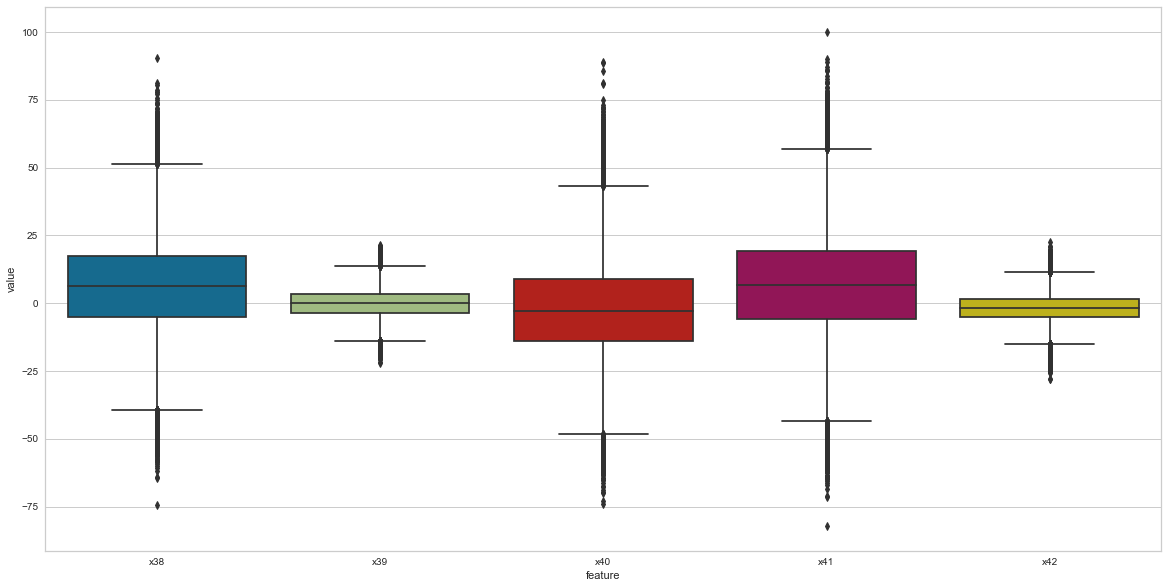

In [24]:
by_value = pd.DataFrame(
    final_data[floats[35:40]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[35:40]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[35:40]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[35:40]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[35:40]]
summary

,x43,x44,x45,x46,x47,x48,x49
count,159963.000000,159960.000000,159971.000000,159969.000000,159963.000000,159968.000000,159968.000000
mean,-0.002091,-0.006250,0.000885,-12.755395,0.028622,-0.000224,-0.674224
std,1.534952,4.164595,0.396621,36.608641,4.788157,1.935501,15.036738
min,-6.876234,-17.983487,-1.753221,-201.826828,-21.086333,-8.490155,-65.791191
25%,-1.039677,-2.812055,-0.266518,-36.428329,-3.216016,-1.320800,-10.931753
50%,-0.004385,-0.010484,0.001645,-12.982497,0.035865,-0.011993,-0.574410
75%,1.033275,2.783274,0.269049,11.445443,3.268028,1.317703,9.651072
max,6.680922,19.069758,1.669205,150.859415,20.836854,8.226552,66.877604
pcnt_na,0.023125,0.025000,0.018125,0.019375,0.023125,0.020000,0.020000
skew,0.013367,0.007382,0.000329,-0.066039,-0.003876,0.012123,-0.025269


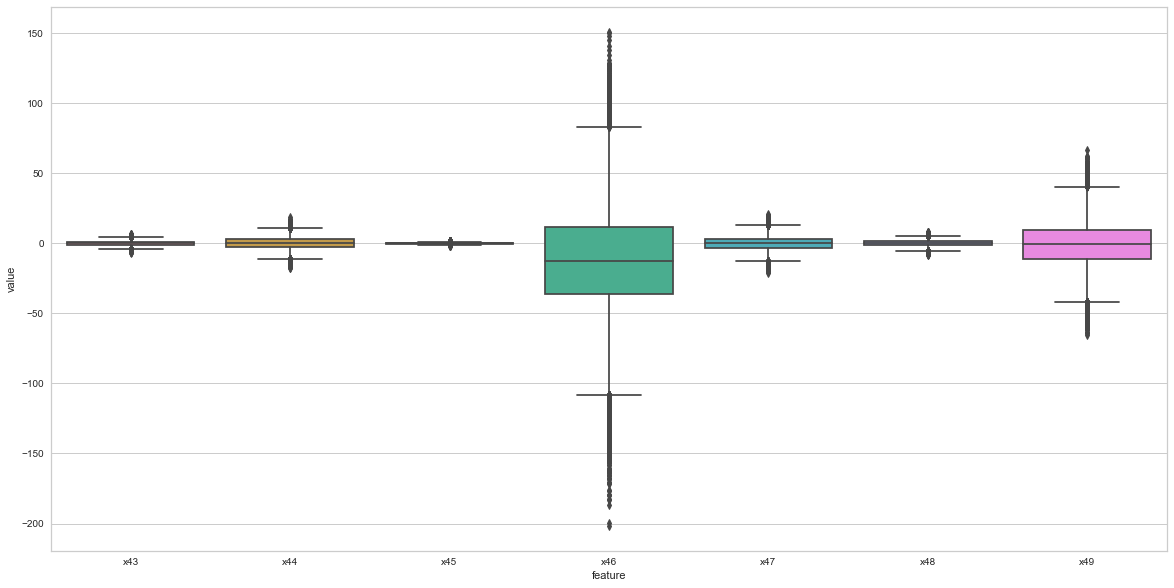

In [25]:
by_value = pd.DataFrame(
    final_data[floats[40:]].unstack()).reset_index().rename(columns={
        0: 'value',
        'level_0': 'feature'
    })
plt.figure(figsize=(20,10))
sns.boxplot(x=by_value['feature'],
               y=by_value['value'])
summary = final_data[floats[40:]].describe()
summary.loc['pcnt_na'] = [(sum(final_data[x].isna())/final_data.shape[0])*100 for x in floats[40:]]
summary.loc['skew'] = [stats.skew(final_data[x].fillna(0)) for x in floats[40:]]
summary.loc['kurt'] = [stats.kurtosis(final_data[x].fillna(0)) for x in floats[40:]]
summary

### Further Distribution Analysis

Below we will use histograms to dive in deeper into the distribution analysis for each variable from the dataset. 

The histogram further illustrates why the variable x37 sticks out from the other variables. The histogram highlights the positive skewness since the tail on the right side of the distribution is longer. The mean (797.18) and median seem to be greater than the mode.

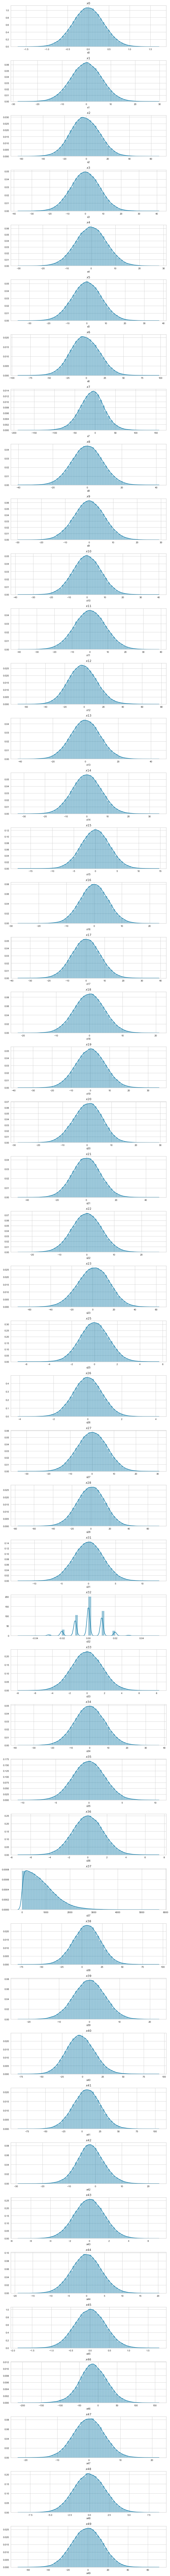

In [26]:
fig, ax = plt.subplots(nrows=len(floats), figsize=(10, 150))
ax.ravel()
histograms = {}
for i, col in enumerate(floats):
    p = sns.distplot(final_data[col], ax=ax[i], label=None)
    p.set_title(f'${col}$')
    histograms.update({col:p})
plt.tight_layout()

### Class Balance

In order to properly calibrate our model to ensure the minimum penalty we need to be aware of what the balance is between the classes in our target variable **y**.

In [27]:
final_data.groupby(['y'])['x0'].count()/final_data.shape[0]

y
0    0.598650
1    0.401187
Name: x0, dtype: float64

In [28]:
final_data.drop(columns=['x2', 'x41'], inplace=True)

The data shows a slight imbalance towards our negative class. This could be problematic given the client constraints surrounding false negatives. If our algortihm is trained to predict the negative class too often it runs the risk of paying a high penalty for false negatives (which must be avoided at all costs)

In [29]:
xform_data = transform_data(final_data[[x for x in final_data.columns[:-1]]].copy())

In [30]:
xform_data

,x0,x1,x3,x4,x5,x6,x7,x8,x9,x10,...,month_Mar,month_May,month_Nov,month_Oct,month_sept.,day_of_week_friday,day_of_week_monday,day_of_week_thurday,day_of_week_tuesday,day_of_week_wednesday
0,-0.446058,-0.625059,0.310829,-0.281989,0.103154,0.434754,-0.232398,-0.113491,-0.662595,0.785889,...,0,0,0,0,0,0,0,0,1,0
1,-0.401142,-0.092590,0.517973,1.007145,-0.318226,2.184158,0.031663,0.104146,0.051099,-1.488004,...,0,0,0,0,0,0,0,0,0,1
2,-0.864117,-0.225734,0.819873,-0.831135,-1.476650,1.009666,0.614063,0.601806,-0.415214,0.199534,...,0,0,0,0,0,0,0,0,0,1
3,-0.659021,0.800509,0.454106,1.019525,0.296857,-1.732962,-0.367422,-0.034436,-0.877112,-0.254436,...,0,0,0,0,0,0,0,0,0,1
4,-0.733857,0.048101,0.210985,0.458963,-0.082200,-0.768776,1.153419,0.138222,-0.678986,0.846885,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,-1.309589,-0.673746,-0.244019,0.275489,-0.154046,0.118027,1.597177,-0.212644,-0.374491,-0.097816,...,0,0,0,0,0,0,0,0,0,1
159996,2.227142,0.757558,1.413174,0.268962,0.909770,1.756328,-0.150145,-0.430371,1.055904,-0.823173,...,0,1,0,0,0,0,0,0,0,1
159997,-2.159656,0.845621,-0.926509,0.359744,-0.361141,0.632330,1.644046,0.163082,1.067517,-0.017163,...,0,0,0,0,0,0,0,0,0,1
159998,0.916897,1.200062,-0.347323,0.634097,1.996178,0.491059,-0.083183,0.296669,0.668143,-0.951236,...,0,1,0,0,0,0,0,0,0,1


In [31]:
random_seed = 5
X_train, X_test, y_train, y_test = train_test_split(xform_data,
                                                    final_data['y'],
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=random_seed)
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=random_seed,
                            n_estimators=10)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=5)

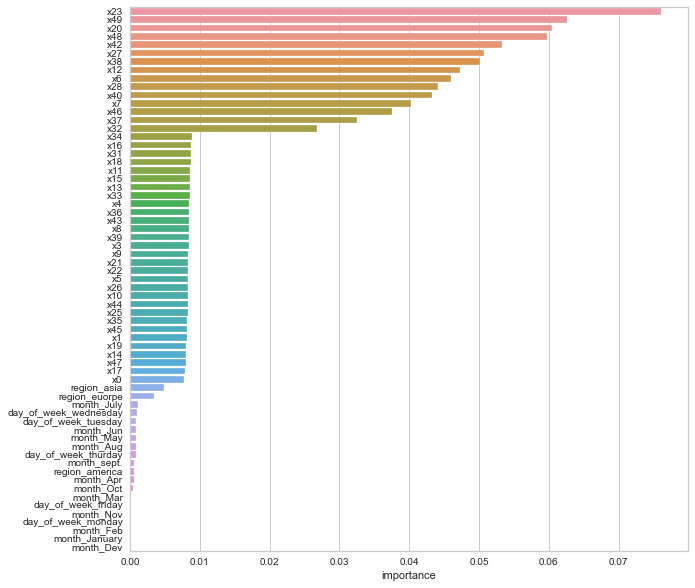

In [32]:
plt.figure(figsize=(10,10))
imp = pd.DataFrame(rf.feature_importances_,
             index=xform_data.columns).rename(columns={
                 0: 'importance'
             }).sort_values(['importance'], ascending=False)
sns.barplot(y=imp.index,
            x=imp['importance'])

From the above barplot, we used feature importance to get a better understanding of the model’s logic. The barplot helps us identify which variables are important. Variables x23, x48 and x49 seems to show the most significance. This is interesting because from the analysis above with the boxplots and histograms, there were signs that x37 had some important features but doesn't show as an important variable in the above barplot. On the flipside, the categorical variables such as the regions, day of week, and month seem to be less important. We can remove variables that are not that significant and have similar or better performance in much shorter training time.

Below we use multiple classifiers such as naive bayes and random forest to analyze the client score.The precision_recall_curve and roc_curve are useful tools to visualize the sensitivity tradeoff in the classifier. They help inform where we should set the decision threshold of the model to maximize sensitivity. 

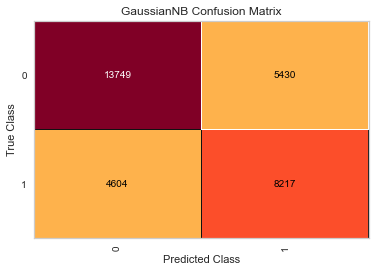

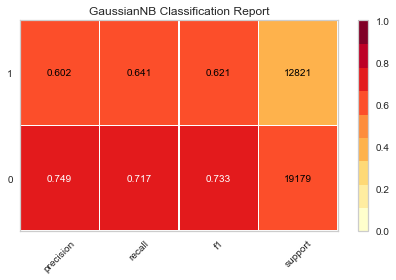

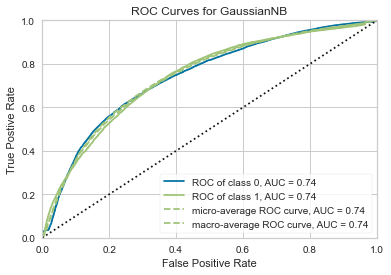

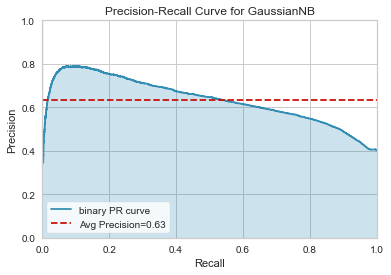

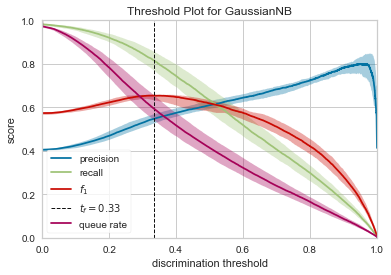

In [33]:
nb = GaussianNB()
nb = nb.fit(X_train, y_train)
disc, cv = analyze_classifier(nb,
                              X_train,
                              X_test,
                              pd.DataFrame(y_train),
                              pd.DataFrame(y_test),
                              discrimination=True)

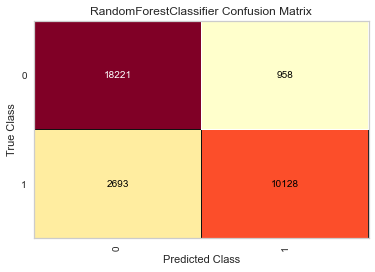

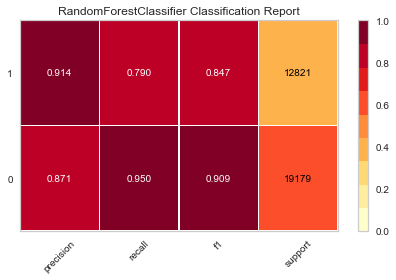

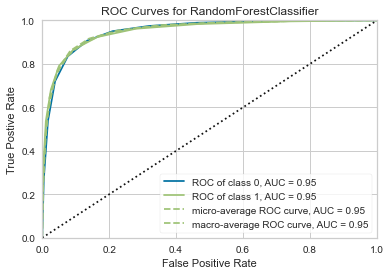

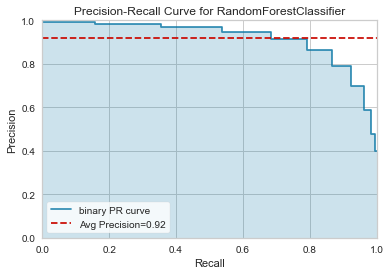

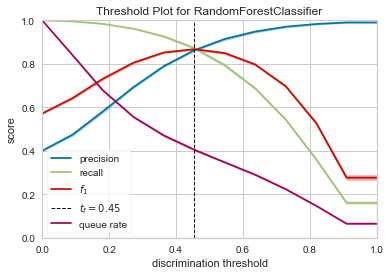

In [34]:
disc_rf, cv_rf = analyze_classifier(rf,
                              X_train,
                              X_test,
                              pd.DataFrame(y_train),
                              pd.DataFrame(y_test),
                              discrimination=True)

In [35]:
probs = rf.predict_proba(X_test)[:,1]

In [36]:
rf.predict(X_test)

array([1, 1, 1, ..., 1, 1, 0])

In [37]:
def client_score(probabilities, test, discrimination_threshold=0.5):
    adjusted_predictions = [(1 if x > discrimination_threshold else 0)
                            for x in probabilities]
    score = [(1 if x == y else 0) for x, y in zip(test, adjusted_predictions)]
    df = pd.DataFrame({
        'adj_pred': adjusted_predictions,
        'score': score,
        'actual': test
    })
    df['prediction_type'] = df.apply(lambda x: map_prediction_type(x), axis=1)
    df['prediction_penalty'] = df.apply(lambda x: map_penalty(x), axis=1)
    return df['prediction_penalty'].sum() #adjusted_predictions, score, df


def map_prediction_type(row):
    if row['actual'] == 1 and row['adj_pred'] == 1:
        return 'TP'
    if row['actual'] == 0 and row['adj_pred'] == 1:
        return 'FP'
    if row['actual'] == 1 and row['adj_pred'] == 0:
        return 'FN'
    if row['actual'] == 0 and row['adj_pred'] == 0:
        return 'TN'

def map_penalty(row):
    if row['actual'] == 1 and row['adj_pred'] == 1:
        return 0
    if row['actual'] == 0 and row['adj_pred'] == 1:
        return -10
    if row['actual'] == 1 and row['adj_pred'] == 0:
        return -500
    if row['actual'] == 0 and row['adj_pred'] == 0:
        return 0

In [38]:
score = client_score(probabilities=rf.predict_proba(X_test)[:,1], test=y_test)

In [39]:
adj[:10]

NameError: name 'adj' is not defined

In [40]:
score[:10]

IndexError: invalid index to scalar variable.

In [ ]:
y_test[:10]

In [42]:
df.groupby(['prediction_type'])[['adj_pred']].count().reset_index()

NameError: name 'df' is not defined

In [78]:
search_space = np.linspace(0, 1, 100)

In [79]:
score

-1356080

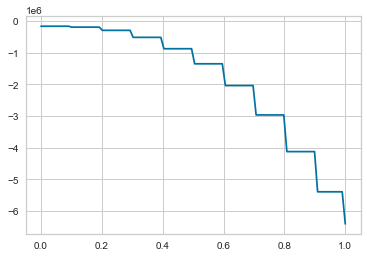

In [80]:
probs  = rf.predict_proba(X_test)[:, 1]
sns.lineplot(x=search_space,
             y=[
                 client_score(probabilities=probs,
                              test=y_test,
                              discrimination_threshold=d) for d in search_space
             ])

In [81]:
compare_classifiers?

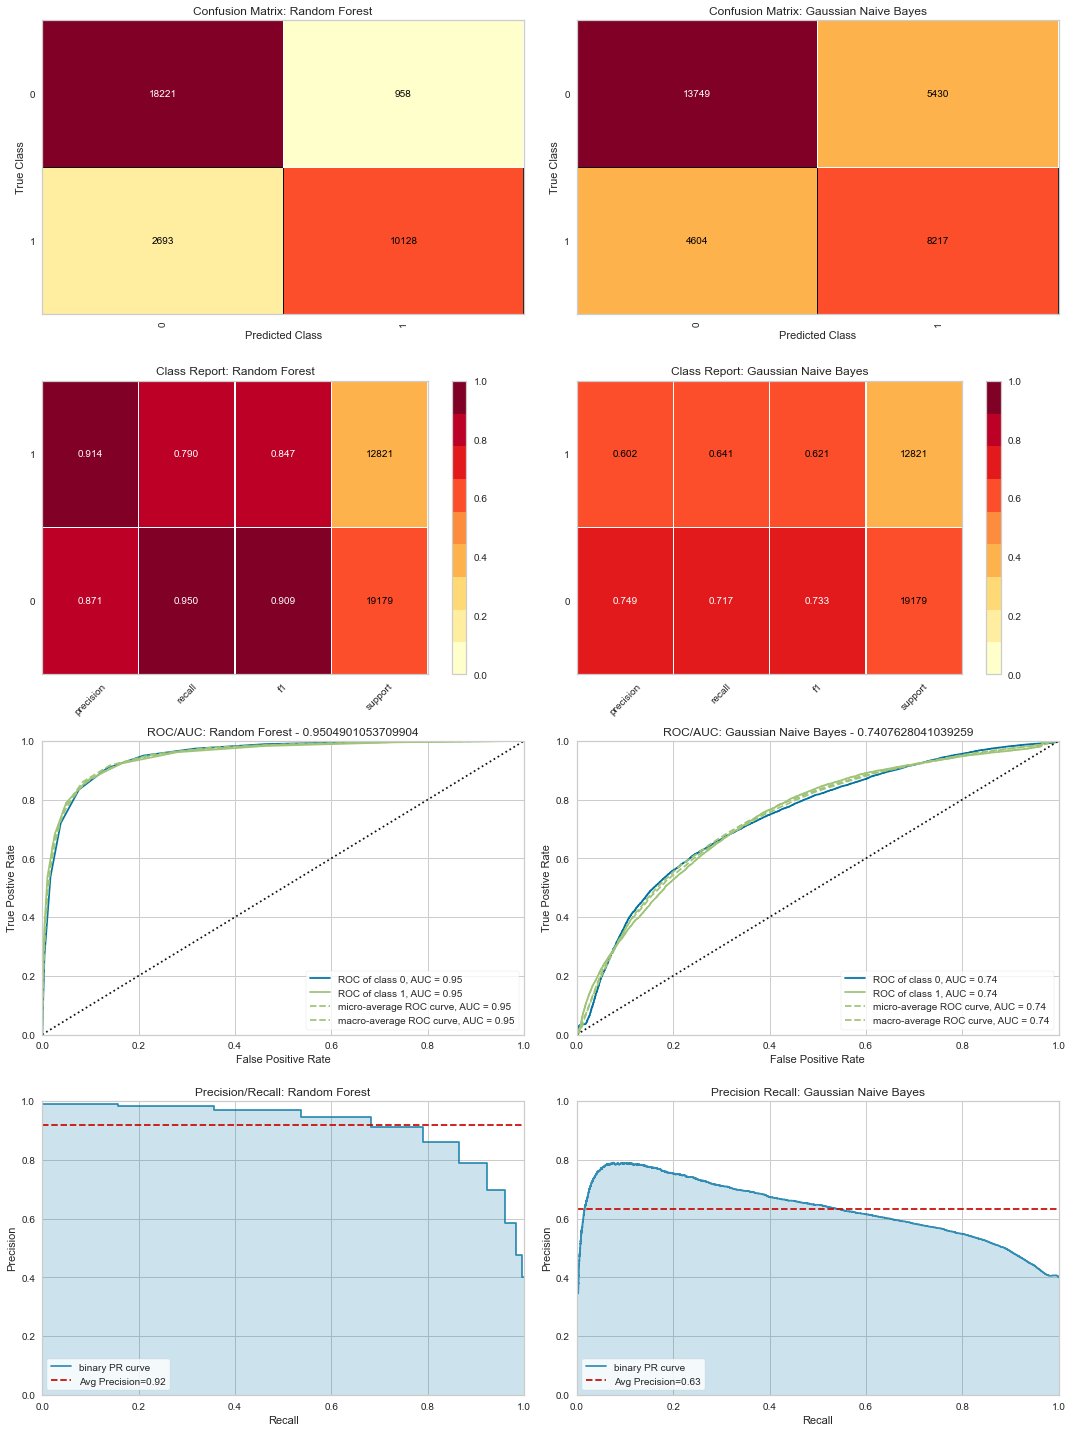

In [82]:
compare_classifiers(rf, nb, 'Random Forest', 'Gaussian Naive Bayes', X_train,
                    X_test, pd.DataFrame(y_train), pd.DataFrame(y_test))

In [44]:
pred_rf = rf.predict(X_test)
probs_rf  = rf.predict_proba(X_test)

In [66]:
x = compute_new_conf_matrix(pred_rf, probs_rf, 0.4, y_test)


In [ ]:
x[0]

In [67]:
x[1]

,No_Predicted,Yes_Predicted
No_True,16006,3173
Yes_True,979,11842


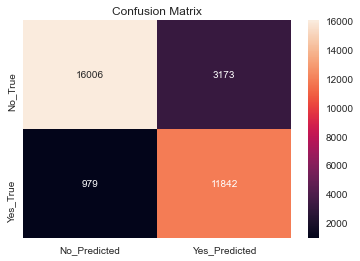

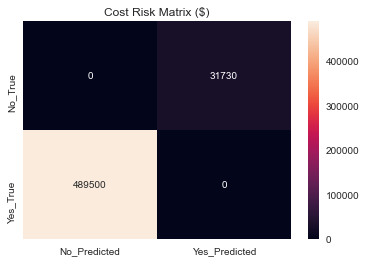

### Evaluation Cost Results

With this model, the cost of our validation False Positives was **$ 31730**

With this model, the cost of our validation False Negatives was **$ 489500**

In [77]:
cfm_copy = x[1].copy()
cfm_copy["No_Predicted"][0] *= 0 # TN
cfm_copy["No_Predicted"][1] *= 500 # FN
cfm_copy["Yes_Predicted"][0] *= 10 # FP
cfm_copy["Yes_Predicted"][1] *= 0 # TP

sns.heatmap(x[1], annot=True, fmt="#").set_title("Confusion Matrix")
plt.show()

sns.heatmap(cfm_copy, annot=True, fmt="#").set_title("Cost Risk Matrix ($)")
plt.show()

display(md("### Evaluation Cost Risk Results"))
display(md(f"With this model, the cost of our validation False Positives was **$ {cfm_copy['Yes_Predicted'][0]}**"))
display(md(f"With this model, the cost of our validation False Negatives was **$ {cfm_copy['No_Predicted'][1]}**"))
